# Generate a thickness map from 4D STEM data

In [1]:
%matplotlib nbagg

In [2]:
import concurrent.futures

import numpy as np
import matplotlib.pyplot as plt
from pacbedclient import query
from libertem.api import Context
from libertem.udf.base import UDF

In [3]:
ctx = Context()

/cachedata/users/weber/PACBED-CNN-env/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36385 instead
  warnings.warn(
2022-07-08 12:05:27,697 - distributed.preloading - INFO - Creating preload: from libertem.executor.dask import worker_setup; worker_setup(resource="CPU", device=8)
2022-07-08 12:05:27,698 - distributed.utils - INFO - Reload module tmpdp7brza3 from .py file
2022-07-08 12:05:27,707 - distributed.preloading - INFO - Import preload module: /tmp/tmpdp7brza3.py
2022-07-08 12:05:27,707 - distributed.preloading - INFO - Creating preload: libertem.preload
2022-07-08 12:05:27,722 - distributed.preloading - INFO - Creating preload: from libertem.executor.dask import worker_setup; worker_setup(resource="CPU", device=15)
2022-07-08 12:05:27,723 - distributed.utils - INFO - Reload module tmpxga69tyb from .py file
2022-07-08 12:05:27,731 - distributed.preloading - 

2022-07-08 12:05:28,123 - distributed.preloading - INFO - Creating preload: from libertem.executor.dask import worker_setup; worker_setup(resource="CPU", device=3)
2022-07-08 12:05:28,124 - distributed.utils - INFO - Reload module tmpw4e60r3s from .py file
2022-07-08 12:05:28,128 - distributed.preloading - INFO - Import preload module: libertem.preload
2022-07-08 12:05:28,133 - distributed.preloading - INFO - Import preload module: /tmp/tmpw4e60r3s.py
2022-07-08 12:05:28,133 - distributed.preloading - INFO - Creating preload: libertem.preload
2022-07-08 12:05:28,191 - distributed.preloading - INFO - Import preload module: libertem.preload
2022-07-08 12:05:28,193 - distributed.preloading - INFO - Import preload module: libertem.preload
2022-07-08 12:05:28,291 - distributed.preloading - INFO - Import preload module: libertem.preload
2022-07-08 12:05:28,303 - distributed.preloading - INFO - Import preload module: libertem.preload
2022-07-08 12:05:28,310 - distributed.preloading - INFO - I

## Load and display example data

In [4]:
stem_ds = ctx.load('EMPAD', '/Users/weber/LargeData/ER-C-1/groups/data_science/data/reference/EMPAD/BiFeO3/acquisition_12.xml')

In [5]:
pick_a = ctx.create_pick_analysis(dataset=stem_ds, y=128, x=128)
pick_res = ctx.run(pick_a)

adf_a = ctx.create_ring_analysis(dataset=stem_ds)
adf_res = ctx.run(adf_a)

<IPython.core.display.Javascript object>


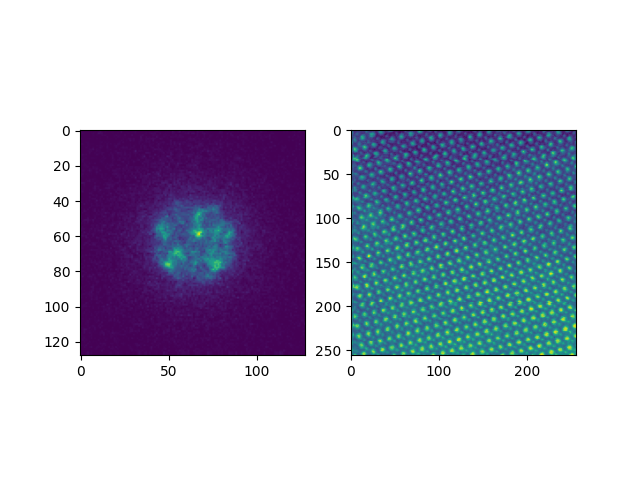

In [6]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow (pick_res['intensity'].raw_data)
axes[1].imshow (adf_res['intensity'].raw_data)

# Generate a map of PACBED images
Sum all patterns in bins using a LibertEM user-defined function.

In [7]:
bin_map = np.zeros(stem_ds.shape.nav, dtype=int)
bin_size = 24
index = 0

for y in range(0, stem_ds.shape.nav[0], bin_size):
    for x in range(0, stem_ds.shape.nav[1], bin_size):
        bin_map[y:y+bin_size, x:x+bin_size] = index
        index += 1
result_shape = ((stem_ds.shape.nav[0] - 1) // bin_size + 1, (stem_ds.shape.nav[1] - 1) // bin_size + 1)

In [8]:
result_shape

(11, 11)

In [9]:
class BinSumUDF(UDF):
    '''
    Sum frames into different bins
    
    Parameters
    ----------
    
    bin_map : AuxBufferWrapper
        Integer aux data of kind nav indicating the bin index for each navigation position.
    '''
    def __init__(self, bin_map: np.ndarray):
        super().__init__(bin_map=bin_map)
    
    def get_result_buffers(self):
        return {
            'intensity': self.buffer(
                kind='sig',
                dtype=np.result_type(self.meta.input_dtype, np.float32),
                extra_shape=(index,)
            )
        }
    
    def process_frame(self, frame):
        index = self.params.bin_map[0]
        self.results.intensity[..., index] += frame
    
    def merge(self, dest, src):
        dest.intensity += src.intensity

In [10]:
aux_map = BinSumUDF.aux_data(data=bin_map, kind='nav', dtype=int)

In [11]:
bin_result = ctx.run_udf(dataset=stem_ds, udf=BinSumUDF(bin_map=aux_map), progress=True)

100%|██████████| 19/19 [00:01<00:00, 14.08it/s]


<IPython.core.display.Javascript object>


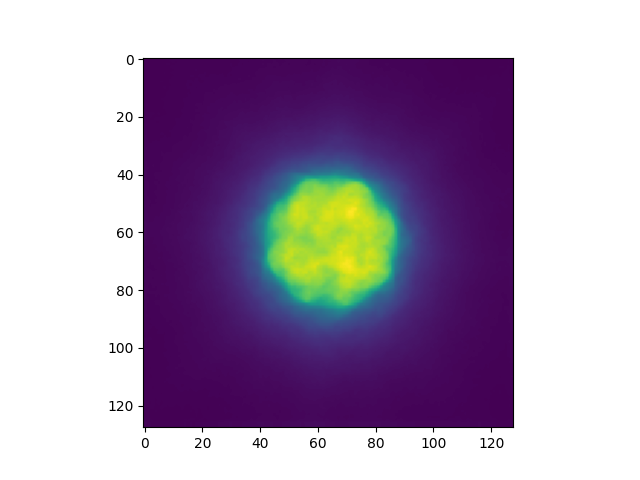

In [12]:
fig, ax = plt.subplots(1)
ax.imshow(bin_result['intensity'].data[..., 0])

## Query the service for each binned image

In [17]:
pool = concurrent.futures.ThreadPoolExecutor(max_workers=4)

In [18]:
def do_query(i):
    print(f"querying {i}...")
    result = query(
        image_array=bin_result['intensity'].data[..., i],
        crystal_structure='Strontium Titanate',
        acceleration_voltage=300000,
        convergence_angle=20,
        zone_u=0, zone_v=0, zone_w=1,
        host='localhost',
        port='8230'
    )
    print(f"{i} done")
    return result

In [19]:
%%time
results = list(pool.map(do_query, range(index)))

querying 0...
querying 1...
querying 2...
querying 3...
2 done
querying 4...
3 done
querying 5...
0 done
querying 6...
1 done
querying 7...
4 done
querying 8...
5 done
querying 9...
6 done
querying 10...
7 done
querying 11...
8 done
querying 12...
9 done
querying 13...
10 done
querying 14...
11 done
querying 15...
13 done
querying 16...
12 done
querying 17...
15 done
querying 18...
14 done
querying 19...
16 done
querying 20...
17 done
querying 21...
18 done
querying 22...
19 done
querying 23...
20 done
querying 24...
21 done
querying 25...
23 done
querying 26...
22 done
querying 27...
24 done
querying 28...
27 done
querying 29...
26 done
querying 30...
25 done
querying 31...
28 done
querying 32...
29 done
querying 33...
30 done
querying 34...
31 done
querying 35...
32 done
querying 36...
33 done
querying 37...
35 done
querying 38...
34 done
querying 39...
36 done
querying 40...
37 done
querying 41...
39 done
querying 42...
38 done
querying 43...
41 done
querying 44...
40 done
querying 

In [20]:
results[0]

{'thickness': 141.0,
 'mistilt': 2.0,
 'scale': 1.0,
 'validation': array([[[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        ...,
 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255]],
 
        [[255, 255, 255, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,

In [21]:
thickness_map = [r['thickness'] for r in results]
thickness_map = np.array(thickness_map).reshape(result_shape)

<IPython.core.display.Javascript object>


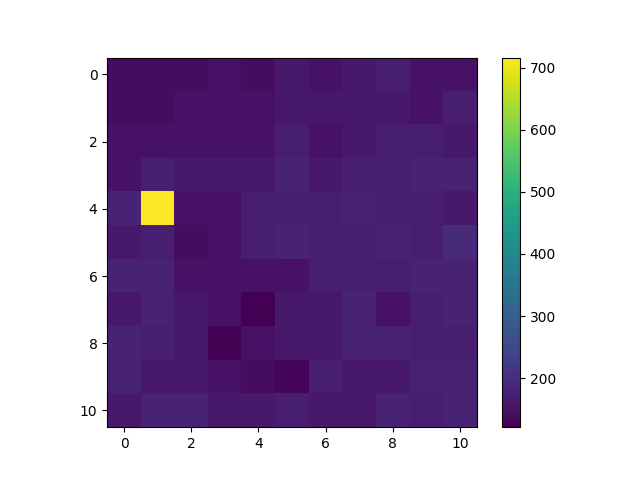

In [22]:
fig, axes = plt.subplots()
im = axes.imshow(thickness_map)
fig.colorbar(im)

In [23]:
mistilt_map = [r['mistilt'] for r in results]
mistilt_map = np.array(mistilt_map).reshape(result_shape)

<IPython.core.display.Javascript object>


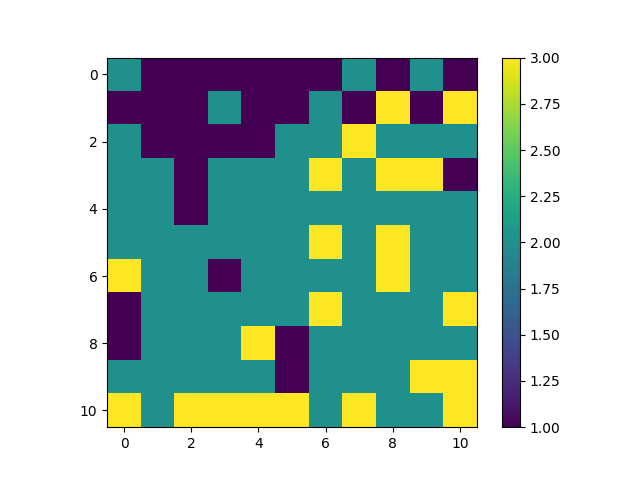

In [24]:
fig, axes = plt.subplots()
im = axes.imshow(mistilt_map)
fig.colorbar(im)

## Inspect results of outliers

<IPython.core.display.Javascript object>


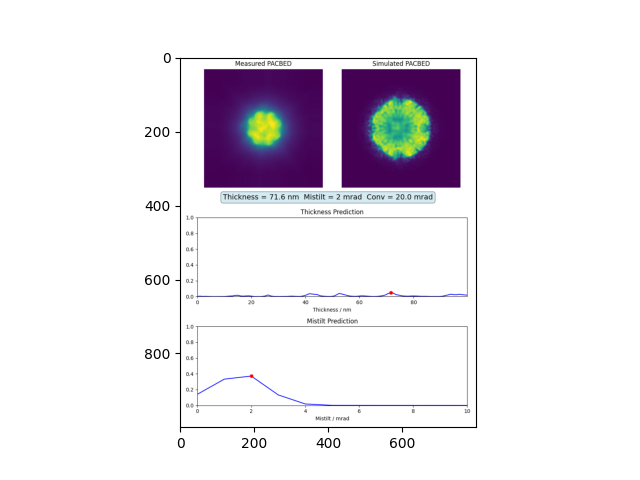

In [25]:
outlier_indices = [4*11 + 1]

for i in outlier_indices:
    fig, axes = plt.subplots()
    axes.imshow(results[i]['validation'])

<IPython.core.display.Javascript object>


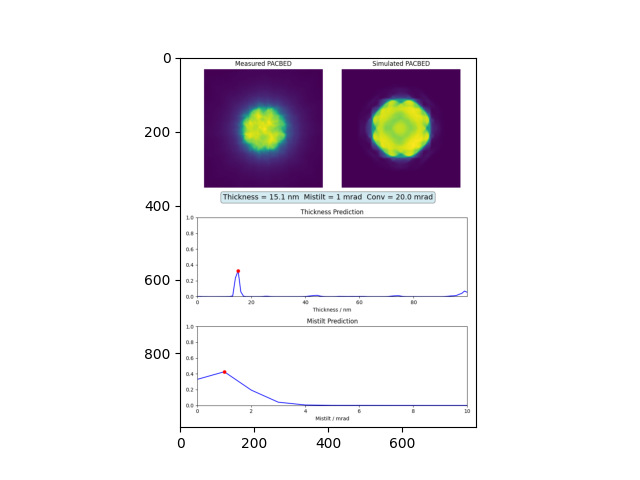

<IPython.core.display.Javascript object>


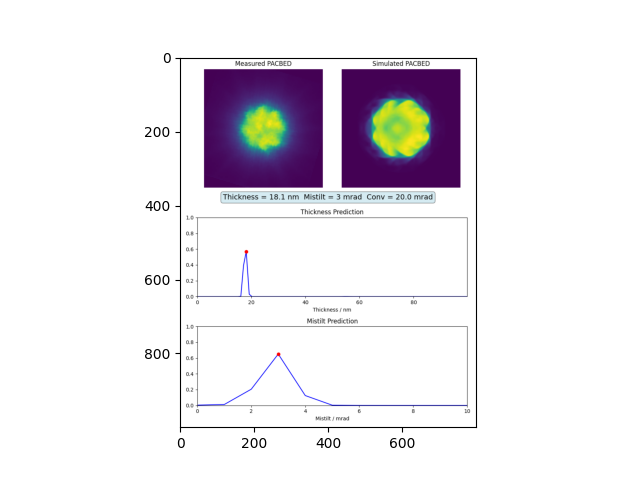

<IPython.core.display.Javascript object>


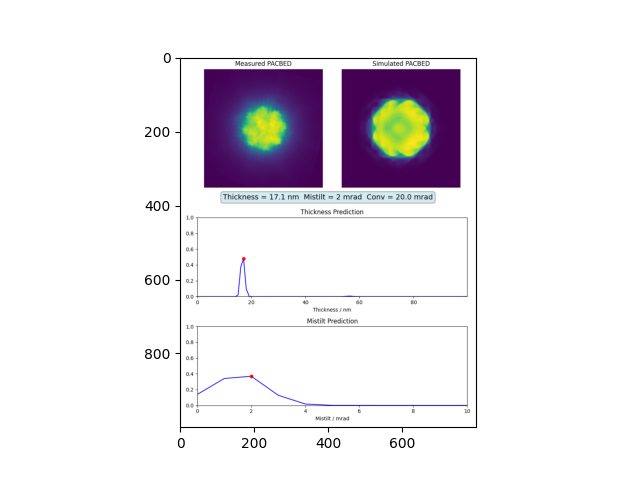

In [26]:
other_indices = [23, 42, 56]

for i in other_indices:
    fig, axes = plt.subplots()
    axes.imshow(results[i]['validation'])